# Chapter 2 – End-to-end Machine Learning project

*This notebook contains all the sample code and solutions to the exercises in chapter 2.*

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Get the Data

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

### Download the Data

In [4]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


def load_housing_data():
    tarball_path = Path("../datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("../datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("../datasets/housing/housing.csv"))


housing = load_housing_data()

In [5]:
housing.sample(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20261,-118.34,33.91,8.0,3937.0,1404.0,2691.0,1142.0,2.4741,185700.0,<1H OCEAN
379,-118.31,33.93,43.0,1834.0,292.0,997.0,295.0,4.9464,150300.0,<1H OCEAN
8088,-121.00,38.58,12.0,3425.0,549.0,1357.0,451.0,5.3344,217500.0,INLAND
4176,-122.34,37.95,44.0,1788.0,368.0,933.0,329.0,2.8750,133400.0,NEAR BAY
1064,-117.29,34.14,45.0,1598.0,314.0,771.0,319.0,2.5417,82900.0,INLAND
19440,-118.32,34.04,48.0,1184.0,328.0,953.0,311.0,2.3526,156300.0,<1H OCEAN
19010,-122.65,38.24,49.0,3273.0,579.0,1431.0,539.0,4.2750,227600.0,<1H OCEAN
4239,-120.06,39.09,30.0,2979.0,583.0,316.0,124.0,2.1987,124000.0,INLAND
13919,-121.80,37.34,20.0,2686.0,414.0,1507.0,405.0,5.8068,263900.0,<1H OCEAN
18181,-122.17,37.75,47.0,998.0,211.0,597.0,185.0,3.1587,100400.0,NEAR BAY


In [6]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path("../images/end_to_end_project")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

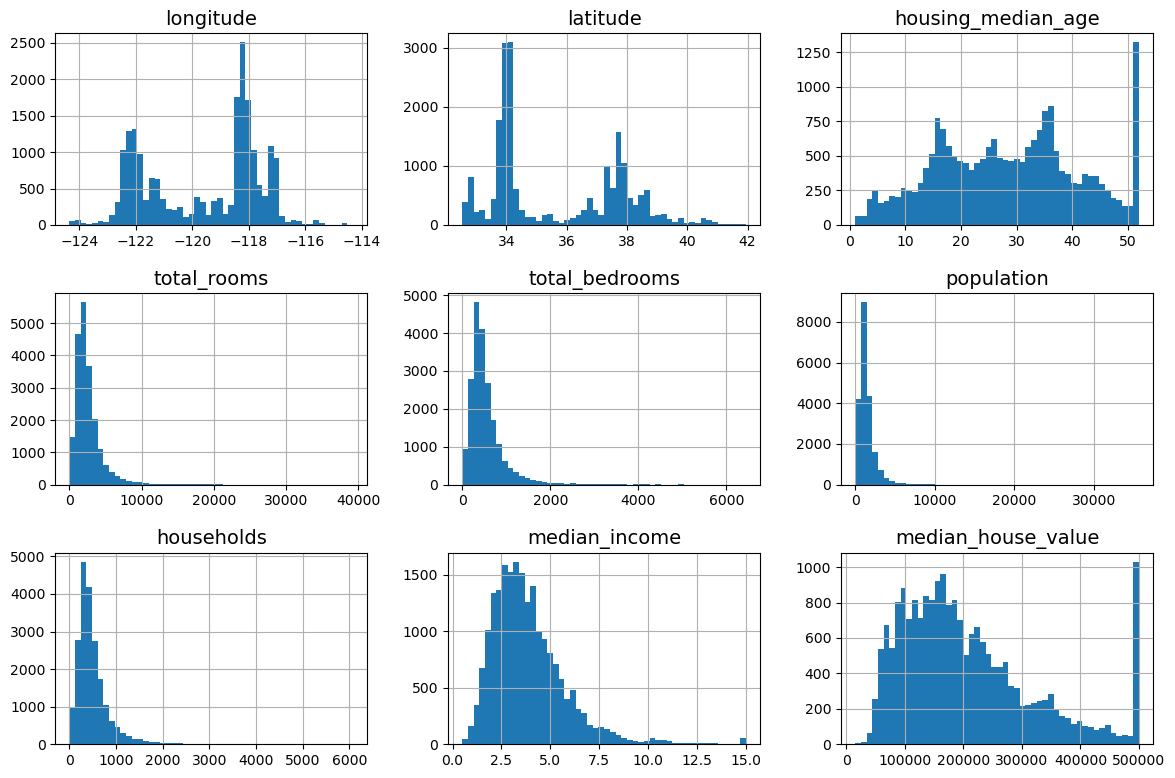

In [8]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

## Create a test set

We're gonna create a test set sampling data in strats. But first we'll discretise `median_income` to create the income starts we need.  

In [12]:
import numpy as np

housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

housing['income_cat'].sample(10)

2766     5
3811     2
8491     3
16733    2
6723     5
17755    2
7207     4
3531     3
7921     2
15460    4
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [13]:
from sklearn.model_selection import train_test_split

housing_train, housing_test = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])

## Visualing the data

<Axes: xlabel='longitude', ylabel='latitude'>

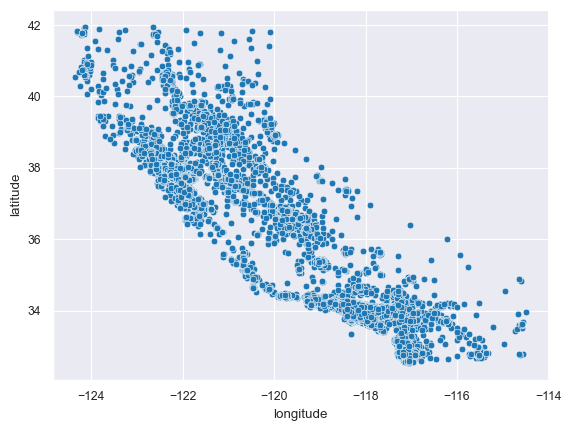

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper')
sns.scatterplot(housing_train, x='longitude', y='latitude')

Adicionando transparência para ter noção da densidade dos pontos no mapa.

<Axes: xlabel='longitude', ylabel='latitude'>

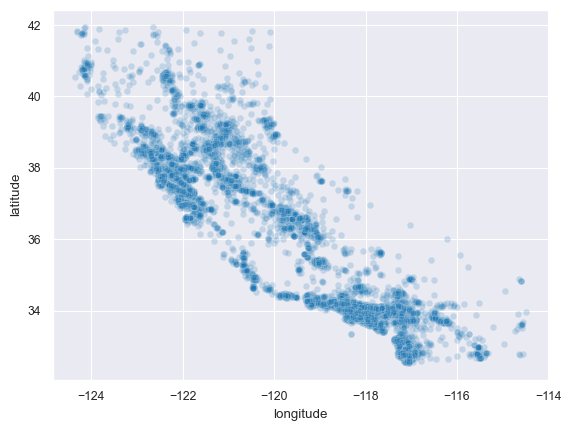

In [23]:
sns.scatterplot(housing_train, x='longitude', y='latitude', alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

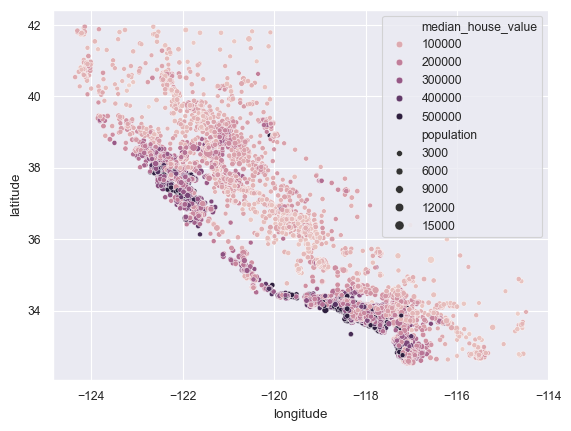

In [36]:
sns.scatterplot(
    housing_train, 
    x='longitude',
    y='latitude',
    size='population',
    hue='median_house_value'
)

## Look for correlations

Note that median_income correlates well with median_price, as expected. Also note that the further north you go, prices tend to slightly drop (this data is from the 90s!).

In [39]:
# In Pandas version 2.0 `numeric_only` now defaults to False 
corr = housing_train.corr(numeric_only=True)

corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

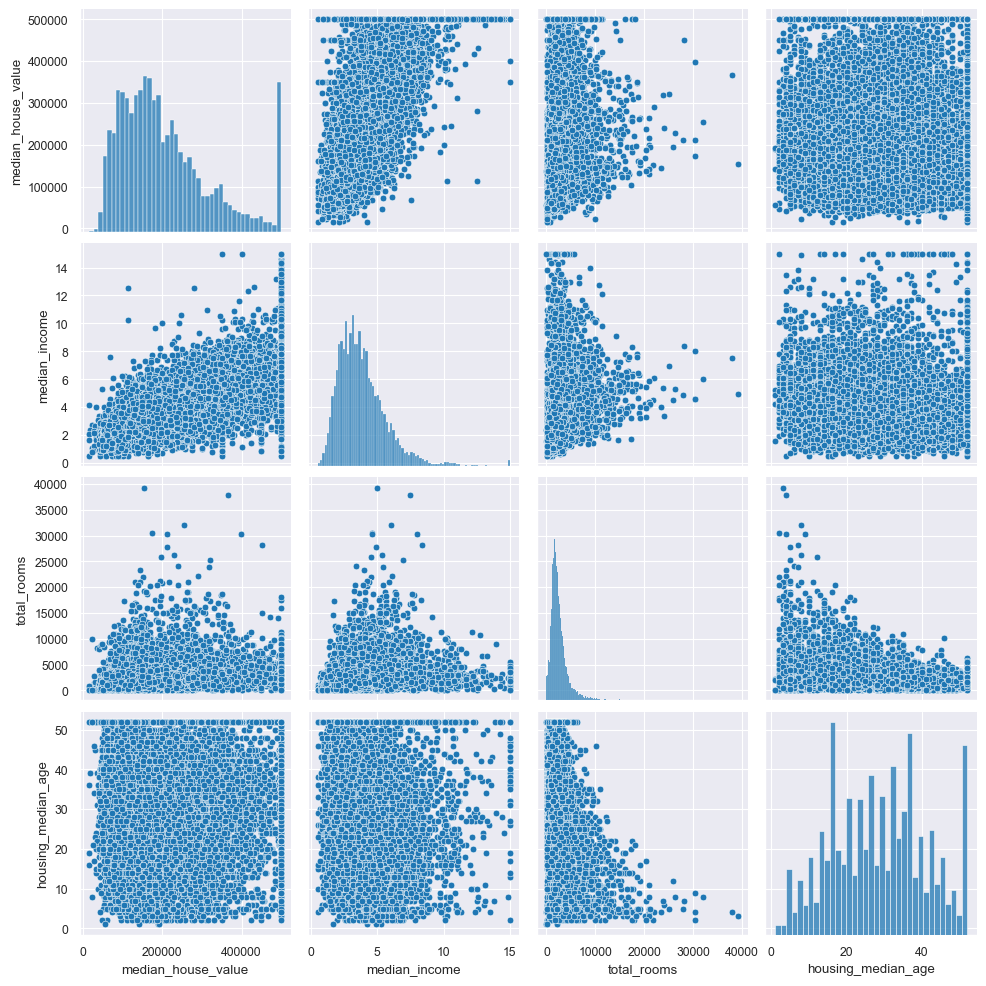

In [42]:
atts = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

sns.pairplot(housing_train[atts])

<Axes: xlabel='median_income', ylabel='median_house_value'>

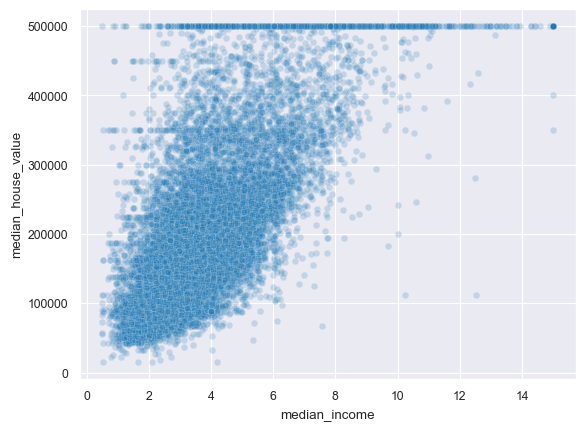

In [45]:
sns.scatterplot(housing_train, x='median_income', y='median_house_value', alpha=0.2)

## Combining attributes

In [46]:
housing_train['rooms_per_house'] = housing_train['total_rooms'] / housing_train['households']
housing_train['bedrooms_ratio'] = housing_train['total_bedrooms'] / housing_train['total_rooms']
housing_train['people_per_house'] = housing_train['population'] / housing_train['households']

In [47]:
corr = housing_train.corr(numeric_only=True)
corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

<Axes: xlabel='bedrooms_ratio', ylabel='median_house_value'>

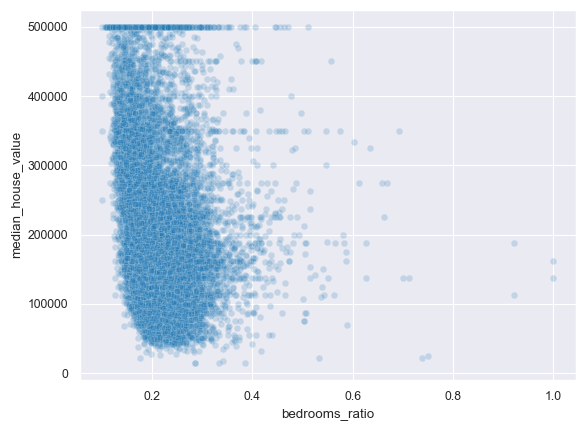

In [49]:
sns.scatterplot(housing_train, x='bedrooms_ratio', y='median_house_value', alpha=0.2)

## Get the data ready for training

In [50]:
housing_labels_train = housing_train['median_house_value']
housing_labels_test = housing_test['median_house_value']
housing_train = housing_train.drop('median_house_value', axis=1)
housing_test = housing_test.drop('median_house_value', axis=1)

## Clean the data